# tascCODA - Tree-aggregated compositional analysis of high-throughput sequencing data

This notebook is a tutorial on how to use tascCODA [Ostner et al., 2021](https://www.frontiersin.org/articles/10.3389/fgene.2021.766405/full) for tree-aggregated compositional analysis of high-throughput sequencing (HTS) data.

For this example, we use single-cell RNA sequencing data. However, there are no limitations to use tascCODA with other HTS data, such as 16S rRNA sequencing.

The particular dataset for this analysis was generated by [Smillie et al, 2019](https://doi.org/10.1016/j.cell.2019.06.029). It contains samples from two different regions in the small intestine of mice - Epithelium and Lamina Propria - and three different inflammation conditions - healthy, non-inflamed and inflamed. In total, we have 365.492 cells from 51 cell types in 133 samples.

This tutorial is designed to be executed on a standard computer (any operating system) in a Python environment with tascCODA, Jupyter notebook and all their dependencies installed. Running the tutorial takes about 5 minutes on a 2020 Apple MacBook Pro (16GB RAM).

In [3]:
# Setup
import numpy as np
import pandas as pd
import re
import toytree as tt
from tasccoda import tree_utils as util
from tasccoda import tree_ana as ana
from tasccoda import tree_results as tr
from tasccoda import tree_agg_model_sslasso as mod
import tasccoda.datasets as dat
import anndata as ad
from sccoda.util import data_visualization as viz
import toyplot
import toyplot.locator
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import toyplot.svg
import os

import importlib

In [4]:
import tasccoda
tasccoda.__version__

'0.1.dev12+g8baba74.d20220628'

## Data setup

First, we read in the per-cell data and convert it to a count table

In [5]:
# read in per-cell data
smillie_data = dat.smillie()
smillie_data["Cluster"] = [str.replace(x, " ", "") for x in smillie_data["Cluster"]]
smillie_data

,NAME,Subject,Sample,Location,Replicate,Health,Cluster,nGene,nUMI,Major_l1,Major_l2,Major_l3,Major_l4
0,N10.EpiA.AAACATACAACCAC,N10,EpiA,Epi,A,Healthy,EnterocyteProgenitors,425,968,Epithelial,Epithelial,Absorptive,Immature cells
1,N10.EpiA.AAACATACAGGCGA,N10,EpiA,Epi,A,Healthy,CyclingTA,1695,7273,Epithelial,Epithelial,Cycling TA3,Cycling TA4
2,N10.EpiA.AAACATACCACTAG,N10,EpiA,Epi,A,Healthy,ImmatureGoblet,391,1190,Epithelial,Epithelial,Secretory,Progenitor cells
3,N10.EpiA.AAACATACCCTTTA,N10,EpiA,Epi,A,Healthy,SecretoryTA,1327,5620,Epithelial,Epithelial,Secretory,Progenitor cells
4,N10.EpiA.AAACATACTGCAAC,N10,EpiA,Epi,A,Healthy,ImmatureEnterocytes2,1383,4676,Epithelial,Epithelial,Absorptive,Immature cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365487,N9.LPB.TTTATCCTAACGAA,N9,LPB,LP,B,Inflamed,Enterocytes,2768,18811,Epithelial,Epithelial,Absorptive,Absorptive Mature cells
365488,N9.LPB.TTTATCCTGTAAAG,N9,LPB,LP,B,Inflamed,Plasma,1392,27685,Immune,Lymphoid,B cells,Plasma4
365489,N9.LPB.TTTATCCTGTCGTA,N9,LPB,LP,B,Inflamed,Plasma,574,5478,Immune,Lymphoid,B cells,Plasma4
365490,N9.LPB.TTTCAGTGGCGTTA,N9,LPB,LP,B,Inflamed,Macrophages,1437,5698,Immune,Myeloid,Monocytes,Macrophages4


In [6]:
# Convert to count table
counts = pd.crosstab(
    [smillie_data["Sample"], smillie_data["Subject"], smillie_data["Location"], smillie_data["Health"], smillie_data["Replicate"]], smillie_data["Cluster"])
counts

obs = pd.DataFrame(index=counts.index).reset_index()
counts

Cluster                                         Best4+Enterocytes  \
Sample Subject Location Health       Replicate                      
EpiA   N10     Epi      Healthy      A                         93   
       N106    Epi      Non-inflamed A                          3   
       N11     Epi      Healthy      A                         93   
       N110    Epi      Non-inflamed A                        221   
       N12     Epi      Non-inflamed A                         18   
...                                                           ...   
LPB2   N111    LP       Inflamed     B2                         1   
       N58     LP       Inflamed     B2                         0   
       N661    LP       Inflamed     B2                         0   
LPB2a  N52     LP       Inflamed     B2a                        1   
LPB2b  N52     LP       Inflamed     B2b                        1   

Cluster                                         CD4+ActivatedFos-hi  \
Sample Subject Location Health       Replicate                        
EpiA   N10     Epi      Healthy      A                            1   
       N106    Epi      Non-inflamed A                            0   
       N11     Epi      Healthy      A                            1   
       N110    Epi      Non-inflamed A                            0   
       N12     Epi      Non-inflamed A                            0   
...                                                             ...   
LPB2   N111    LP       Inflamed     B2                         138   
       N58     LP       Inflamed     B2                           5   
       N661    LP       Inflamed     B2                          82   
LPB2a  N52     LP       Inflamed     B2a                        119   
LPB2b  N52     LP       Inflamed     B2b                        125   

Cluster                                         CD4+ActivatedFos-lo  \
Sample Subject Location Health       Replicate                        
EpiA   N10     Epi      Healthy      A                            2   
       N106    Epi      Non-inflamed A                            0   
       N11     Epi      Healthy      A                            0   
       N110    Epi      Non-inflamed A                            0   
       N12     Epi      Non-inflamed A                            0   
...                                                             ...   
LPB2   N111    LP       Inflamed     B2                          15   
       N58     LP       Inflamed     B2                           1   
       N661    LP       Inflamed     B2                          38   
LPB2a  N52     LP       Inflamed     B2a                        404   
LPB2b  N52     LP       Inflamed     B2b                        404   

Cluster                                         CD4+Memory  CD4+PD1+  \
Sample Subject Location Health       Replicate                         
EpiA   N10     Epi      Healthy      A                  11         5   
       N106    Epi      Non-inflamed A                   0         0   
       N11     Epi      Healthy      A                   8         0   
       N110    Epi      Non-inflamed A                   1         0   
       N12     Epi      Non-inflamed A                   0         0   
...                                                    ...       ...   
LPB2   N111    LP       Inflamed     B2                717        24   
       N58     LP       Inflamed     B2                  1         0   
       N661    LP       Inflamed     B2               1431         0   
LPB2a  N52     LP       Inflamed     B2a               348         0   
LPB2b  N52     LP       Inflamed     B2b               338         0   

Cluster                                         CD69+Mast  CD69-Mast  \
Sample Subject Location Health       Replicate                         
EpiA   N10     Epi      Healthy      A                  2          8   
       N106    Epi      Non-inflamed A                  2          0   
       N11     Epi      Healt

For preprocessing, we need to extract the tree-structured cell lineage information (Lineages `Major_l1` - `Major_l4`) from the data, generate a Newick string through `tasccoda.tree_utils.df2newick()` and convert it into a [toytree](https://toytree.readthedocs.io/en/latest/) object.

In [7]:
# Get cell lineage information for all 51 cell types
vars = smillie_data.groupby("Cluster").agg({
    "Major_l1": "first",
    "Major_l2": "first",
    "Major_l3": "first",
    "Major_l4": "first",
})

# Convert lineage information into a newick string
importlib.reload(util)
tree_levels = ["Major_l1", "Major_l2", "Major_l3", "Major_l4", "Cluster"]
newick = util.df2newick(smillie_data.loc[:, tree_levels].reset_index(drop=True), tree_levels)

# Build tree
tree = tt.tree(newick=newick, tree_format=8)
tree.draw(tip_labels_align=True, node_sizes=10, node_labels='name', width=800, node_markers="r10x1.25", node_colors="lightblue")

(<toyplot.canvas.Canvas at 0x7fd42667a370>,
 <toytree.Render.ToytreeMark at 0x7fd426682820>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="918.0px" viewBox="0 0 800.0 918.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te6043c9392f74339af938ec964e1505a"> CD4+T CD8+T Plasma4 Follicular4 GC4 CyclingB4 ILCs4 NKs4 DCs CyclingMonocytes4 InflammatoryMonocytes4 Macrophages4 CD69-Mast4 CD69+Mast4 Immaturecells AbsorptiveMaturecells TAcells SecretoryMaturecells Progenitorcells Mcells4 Stem4 CyclingTA4 WNT2B+ WNT5B+ Myofibroblast4 InflammatoryFibroblast4 EndothelialCells Glia4 Tcells Bcells ILCs3 NKs3 Monocytes Mast Absorptive Secretory Mcells3 Stem3 CyclingTA3 Fibroblasts Endothelial3 Glia3 Lymphoid Myeloid Epithelial Stromal Immune Epithelial Stromal Tregs MT-hi CD4+ActivatedFos-hi CD4+PD1+ CD4+ActivatedFos-lo CD4+Memory CD8+IL17+ CyclingT CD8+LP CD8+IELs Plasma Follicular GC CyclingB ILCs NKs DC1 DC2 CyclingMonocytes InflammatoryMonocytes Macrophages CD69-Mast CD69+Mast ImmatureEnterocytes1 ImmatureEnterocytes2 EnterocyteProgenitors Enterocytes Best4+Enterocytes TA2 TA1 Tuft Goblet Enteroendocrine SecretoryTA ImmatureGoblet Mcells Stem CyclingTA WNT2B+Fos-lo2 RSPO3+ WNT2B+Fos-lo1 WNT2B+Fos-hi WNT5B+1 WNT5B+2 Myofibroblasts InflammatoryFibroblasts Post-capillaryVenules Endothelial Microvascular Pericytes Glia

Now, we can put everything together into an [anndata](https://anndata.readthedocs.io/en/latest/) object that we use in tascCODA:

In [8]:
data = ad.AnnData(X=counts.reset_index(drop=True), var=vars, obs=obs, uns={"newick": newick, "phylo_tree": tree})

/Users/johannes.ostner/opt/anaconda3/envs/scCODA_tf2.8/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


For this tutorial, we focus on finding changes between healthy and non-inflamed tissue in the Lamina Propria. Therefore, we subset the data accordingly, and end up with 48 samples:

In [9]:
data_LP_hn = data[(data.obs["Health"].isin(["Healthy", "Non-inflamed"])) & (data.obs["Location"] == "LP")]
data_LP_hn

View of AnnData object with n_obs × n_vars = 48 × 51
    obs: 'Sample', 'Subject', 'Location', 'Health', 'Replicate'
    var: 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4'
    uns: 'newick', 'phylo_tree'

A quick plot of the data with the `sccoda.util.data_visualization` module shows us that there are some changes in relative abundance in the data:

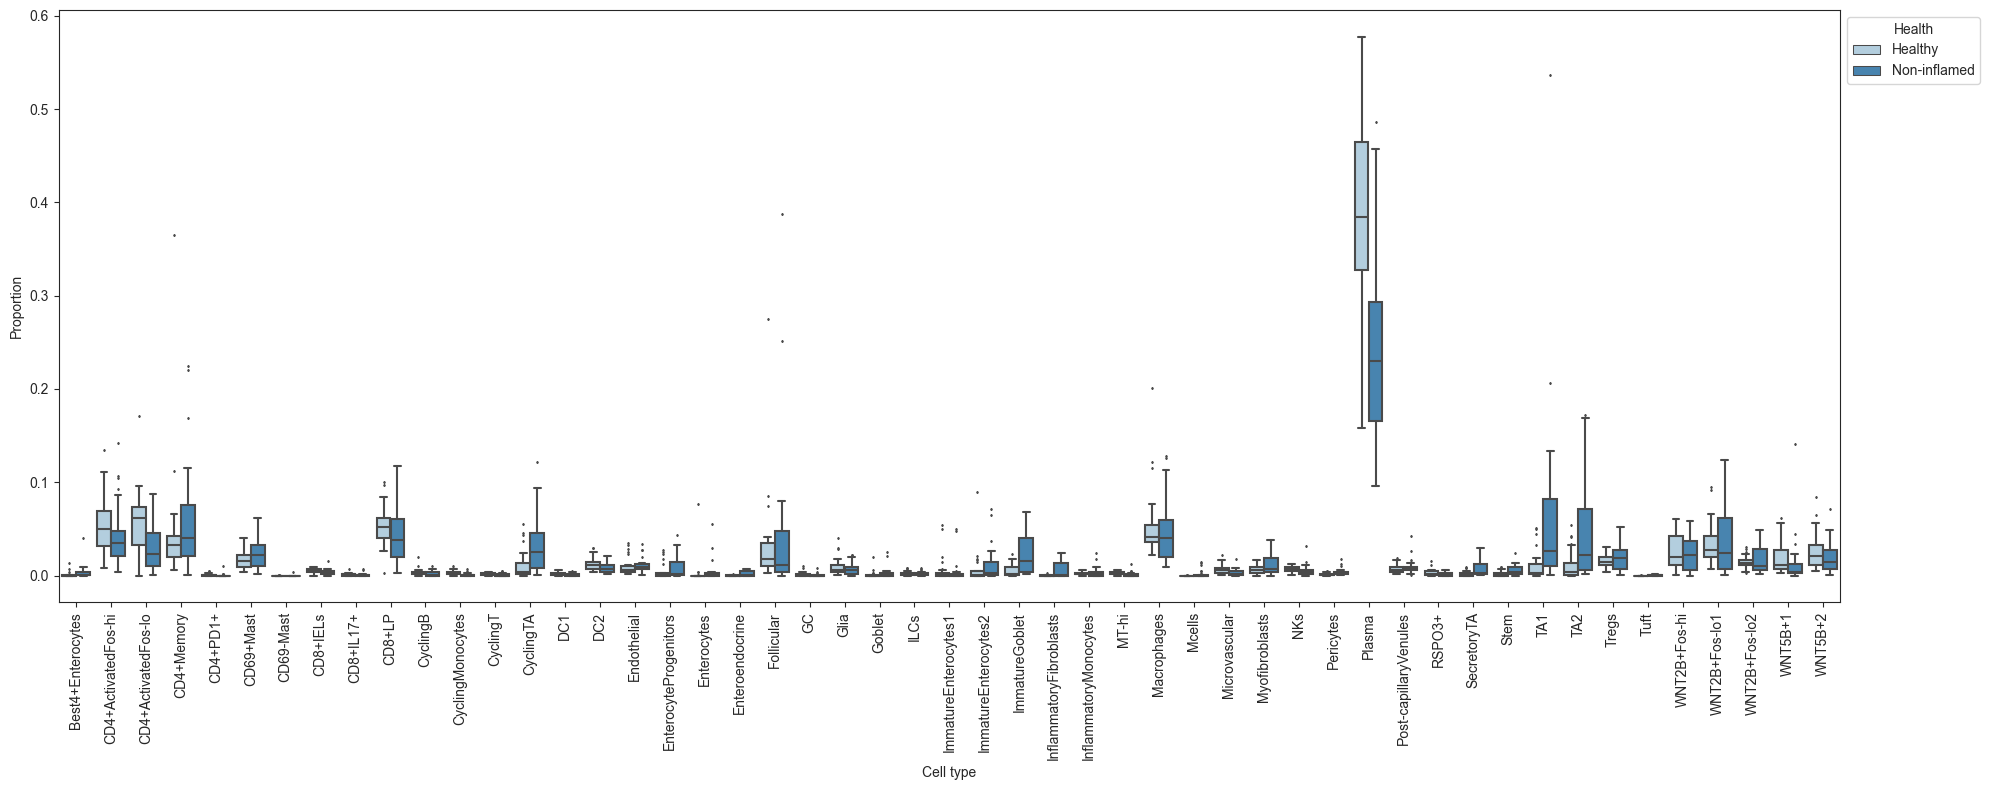

In [10]:
viz.boxplots(data_LP_hn, feature_name="Health", figsize=(20, 8))
plt.show()

## Run tascCODA

Running tascCODA on our data is now simply a matter of running the HMC sampling process. The model creation and inference works analogous to scCODA (see the tutorial [here](https://sccoda.readthedocs.io/en/latest/getting_started.html))

As hyperparameters, we have to specify (see the tascCODA paper for further explanations):
- The reference cell type (which is assumed to be unchanged between the conditions): We use the `automatic` setting here, which chooses a reference that induces minimal compositional effects (NK cells)
- The model formula (R-style formula string, just as in scCODA)
- The aggregation bias $\phi$. We go with an unbiased aggregation (`pen_args={"phi": 0}`) here.

THen, we run HMC sampling via `sample_hmc_da` with the default settings of 20.000 samples, of which 5.000 are discarded as burn-in

In [11]:
importlib.reload(ana)
tree_mod= ana.CompositionalAnalysisTree(
            data_LP_hn.copy(),
            reference_cell_type="automatic",
            formula="Health",
            reg="scaled_3",
            pen_args={"phi": 0}
        )

tree_res = tree_mod.sample_hmc_da()

Automatic reference selection! Reference cell type set to NKs
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:11<00:00, 104.58it/s]


MCMC sampling finished. (256.026 sec)
Acceptance rate: 87.7%


/Users/johannes.ostner/opt/anaconda3/envs/scCODA_tf2.8/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (15000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


## Result analysis

Calling `summary()` on the results object, we can see the most relevant information for further analysis:



In [12]:
tree_res.summary()

Compositional Analysis summary:

Data: 48 samples, 51 cell types
Reference index: 29
Formula: Health

Intercepts:
                         Final Parameter  Expected Sample
Cell Type                                                
Tregs                              0.643        69.265072
MT-hi                             -0.755        17.114752
CD4+ActivatedFos-hi                1.491       161.732019
CD4+PD1+                          -0.962        13.914629
CD4+ActivatedFos-lo                1.429       152.009157
CD4+Memory                         1.281       131.097427
CD8+IL17+                         -0.837        15.767341
CyclingT                          -0.740        17.373408
CD8+LP                             1.524       167.158216
CD8+IELs                          -0.149        31.372784
Plasma                             3.489      1192.659259
Follicular                         0.808        81.690749
GC                                -0.907        14.701371
CyclingB        

**Model properties**

First, the summary shows an overview over the model properties:
* Number of samples/cell types
* The reference cell type.
* The formula used

The model has three types of parameters that are relevant for analysis - intercepts, feature-level effects and node-wise effects.
These can be interpreted like in a standard regression model:
Intercepts show how the cell types are distributed without any active covariates, effects show how the covariates influence the cell types.

**Intercepts**

The first column of the intercept summary shows the parameters determined by the MCMC inference.

The "Expected sample" column gives some context to the numerical values.
If we had a new sample (with no active covariates) with a total number of cells equal to the mean sampling depth of the dataset,
then this distribution over the cell types would be most likely.

**Feature-level Effects**

For the feature-level effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types, as sums over node-level effects on all parent nodes.
Most important is the distinction between zero and non-zero entries
A value of zero means that no statistically credible effect was detected.
For a value other than zero, a credible change was detected. A positive sign indicates an increase, a negative sign a decrease in abundance.

Since the numerical values of the "Effect" column are not straightforward to interpret, the "Expected sample" and "log2-fold change" columns give us an idea on the magnitude of the change.
The expected sample is calculated for each covariate separately (covariate value = 1, all other covariates = 0), with the same method as for the intercepts.
The log-fold change is then calculated between this expected sample and the expected sample with no active covariates from the intercept section.
Since the data is compositional, cell types for which no credible change was detected, will still change in abundance as well, as soon as a credible effect is detected on another cell type due to the sum-to-one constraint.
If there are no credible effects for a covariate, its expected sample will be identical to the intercept sample, therefore the log2-fold change is 0.

**Node-level effects**

These parameters are the most important ones. They describe, at which points in the tree a credible change in abundance was detected. The data frame just has two columns:
The "Final Parameter" column shows the effect values, the "Is credible" column simply depicts whether the inferred effect is different from 0, i.e. credible.
In a normal tascCODA analysis, we are interested in which subtrees (i.e. nodes) have a nonzero effect, which we can easily extract:

In [13]:
print(tree_res.node_df[tree_res.node_df["Is credible"] == True])

                                        Final Parameter  Median  HDI 3%  \
Covariate                   Node                                          
Health[T.Non-inflamed]_node Plasma               -0.090  -0.090  -0.538   
                            Tcells               -0.618  -0.618  -0.794   
                            Bcells               -0.758  -0.758  -1.014   
                            Monocytes            -0.201  -0.201  -0.610   
                            Myeloid              -0.207  -0.207  -0.545   
                            Epithelial            0.143   0.143  -0.013   
                            Stromal              -0.321  -0.321  -0.490   

                                        HDI 97%     SD     Delta  Is credible  
Covariate                   Node                                               
Health[T.Non-inflamed]_node Plasma        0.033  0.188  0.065919         True  
                            Tcells       -0.432  0.097  0.065919         True  
    


**Interpretation**

We see that most credible effects are on intermediate nodes. The only slight increase in abundance is on all Epithelial cell types, while there are decreases on Stromal and some Immune cell types.
The most important decreases (i.e. with the largest effect sizes) can be found on B- and T-cells.
Plasma cells have an additional decrease, meaning that they change even stronger in abundance than the rest of the B-cell lineage

We can also easily plot the credible effects as nodes on the tree for better visualization. Perfectly aligning and styling the plot might require some handwork though:

In [15]:
tree_res.draw_tree_effects(tree=data.uns["phylo_tree"], node_labels='name', width=800, node_labels_style={"font-size": "11px", "-toyplot-anchor-shift":"30px"}, tip_labels_align=True,)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="918.0px" viewBox="0 0 800.0 918.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te92635758347449d8b1e2d34817ccccf"> CD4+T CD8+T DCs Immaturecells AbsorptiveMaturecells TAcells SecretoryMaturecells Progenitorcells WNT2B+ WNT5B+ Tcells Bcells Monocytes Mast Absorptive Secretory EndothelialCells Fibroblasts Lymphoid Myeloid Epithelial Stromal Immune Mcells Stem CyclingTA ImmatureEnterocytes1 ImmatureEnterocytes2 EnterocyteProgenitors Enterocytes Best4+Enterocytes TA2 TA1 Tuft Goblet Enteroendocrine SecretoryTA ImmatureGoblet Post-capillaryVenules Endothelial Microvascular Pericytes Glia Myofibroblasts InflammatoryFibroblasts WNT2B+Fos-lo2 RSPO3+ WNT2B+Fos-lo1 WNT2B+Fos-hi WNT5B+1 WNT5B+2 ILCs NKs Tregs MT-hi CD4+ActivatedFos-hi CD4+PD1+ CD4+ActivatedFos-lo CD4+Memory CD8+IL17+ CyclingT CD8+LP CD8+IELs Plasma Follicular GC CyclingB CyclingMonocytes InflammatoryMonocytes Macrophages DC1 DC2 CD69-Mast CD69+Mast

In [19]:
tree_res.get_significant_results()

{'Nodes': ['Plasma',
  'Tcells',
  'Bcells',
  'Monocytes',
  'Myeloid',
  'Epithelial',
  'Stromal'],
 'Cell types': ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '50']}